In [1]:
# Libraries and figure settings
%matplotlib inline

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#import seaborn as sns
import requests
import time
import matplotlib
plt.style.use('fivethirtyeight')

### TODO: 
- Simplificar nombres CCAA
- Calcular total nacional
- Calcular valores per capita
- Mostrar lineas verticales en las visualizaciones
- Arreglar figura superior

## COVID-19 data analysis

Voy a utilizar el dataset del centro nacional de epidemiologia (se actualiza todos los dias)

In [2]:
req = requests.get("https://covid19.isciii.es/resources/serie_historica_acumulados.csv")
csv = req.content.decode('ISO-8859-1')

filename = 'serie_historica_acumulados.csv'
with open(filename, 'w') as f:
    f.write(csv)

### Obtengo el censo de CCAA de España

Una vez más, los datos los he sacado de https://datos.gob.es/

```
https://datos.gob.es/es/catalogo/ea0010587-poblacion-por-sexo-edad-grupos-quinquenales-y-pais-de-nacimiento-comunidades-autonomas-y-provincias-censos-de-poblacion-y-viviendas-identificador-api-t20-e244-avance-p01-l0-04007-px
```


In [3]:
censo=pd.read_csv('censo_espana_2011.csv', skiprows=5, nrows=63, sep=';', header=[0,1], index_col=0) # a partir de esta fila segregan los datos por pais de origen

censo_total = censo['Ambos sexos'].reset_index()
censo_total['TOTAL'] = censo_total['TOTAL'].apply(lambda x: x.strip()) # elimino espacios innecesarios
censo_total['Total'] = censo_total['Total'].apply(lambda x: int(x.replace('.', '')))

es_ccaa = censo_total.TOTAL == censo_total.TOTAL.apply(lambda x: x.upper()) # las CCAA vienen en todo mayusculas
ceuta_melilla = censo_total.TOTAL.isin(['Ceuta', 'Melilla'])
censo_ccaa = censo_total[es_ccaa | ceuta_melilla].reset_index(drop=True)

censo_ccaa = censo_ccaa.rename(columns={'TOTAL':'CCAA', 'Total':'Poblacion'})

censo_ccaa['CCAA'] = censo_ccaa['CCAA'].apply(lambda x: x.lower().title()) # title es como capitalize() pero para todas las palabras de la cadena
censo_ccaa

# censo_ccaa[censo_ccaa.CCAA != 'Total Nacional'].Poblacion.sum()  # 46815919 check

,CCAA,Poblacion
0,Total Nacional,46815916
1,Andalucía,8371270
2,Aragón,1344509
3,"Asturias, Principado De",1075183
4,"Balears, Illes",1100503
5,Canarias,2082655
6,Cantabria,592542
7,Castilla Y León,2540188
8,Castilla-La Mancha,2106331
9,Cataluña,7519843


In [4]:
nombres_ccaa = {'AN':'Andalucía', 'AR':'Aragón', 'AS':'Asturias, Principado De', 'CB':'Cantabria', 'CE':'Ceuta',
                'CL':'Castilla Y León', 'CM':'Castilla-La Mancha', 'CN':'Canarias', 'CT':'Cataluña', 'EX':'Extremadura',
                'GA':'Galicia','IB':'Balears, Illes', 'MC':'Murcia, Región De', 'MD':'Madrid, Comunidad De', 'ME':'Melilla',
                'NC':'Navarra, Comunidad Foral De','PV':'País Vasco', 'RI':'Rioja, La', 'VC':'Comunitat Valenciana'
               }

### Parseo los datos de la epidemia

In [10]:
df = pd.read_csv('serie_historica_acumulados.csv', parse_dates=[1], infer_datetime_format=True )
df = df[:-1]  # elimino comentario de la ultima fila
df = df.rename(columns={'CCAA Codigo ISO':'CCAA', 'Casos ':'Casos'})
df = df.fillna(0)
df['CCAA'] = df['CCAA'].apply(lambda x: nombres_ccaa[x])

# Elimino los registros sin casos
df = df[df['Casos'] > 0]

# Calculo los nuevos casos por CCAA y el total nacional
df = df.sort_values(by=['CCAA','Fecha']).reset_index(drop=True)

total_nacional = df.groupby('Fecha').sum().reset_index()
total_nacional['CCAA'] = ['Nacional']*len(total_nacional)

df = pd.concat([total_nacional, df], ignore_index=True, sort=False)

df['Activos'] = df['Casos'] - df['Recuperados'] - df['Fallecidos']

for col in ['Casos', 'Activos', 'Fallecidos', 'Recuperados', 'Hospitalizados', 'UCI']: 
    df['nuevos' + col] = df.groupby('CCAA')[col].diff().fillna(0)
    
#[print(df[df.CCAA==ccaa].Activos.is_monotonic, ccaa) for ccaa in df.CCAA.unique()] #todas las CCAA son monotonicas

# Dias desde el inicio de la epidemia por CCAA
df['Dias'] = df.groupby('CCAA')['Fecha'].transform(lambda x: x - x.iloc[0]).dt.days  # magia negra

print(df.dtypes)
df.head()

Fecha                   datetime64[ns]
Casos                          float64
Hospitalizados                 float64
UCI                            float64
Fallecidos                     float64
Recuperados                    float64
CCAA                            object
Activos                        float64
nuevosCasos                    float64
nuevosActivos                  float64
nuevosFallecidos               float64
nuevosRecuperados              float64
nuevosHospitalizados           float64
nuevosUCI                      float64
Dias                             int64
dtype: object


,Fecha,Casos,Hospitalizados,UCI,Fallecidos,Recuperados,CCAA,Activos,nuevosCasos,nuevosActivos,nuevosFallecidos,nuevosRecuperados,nuevosHospitalizados,nuevosUCI,Dias
0,2020-02-20,2.0,0.0,0.0,0.0,0.0,Nacional,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2020-02-21,2.0,0.0,0.0,0.0,0.0,Nacional,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2020-02-22,2.0,0.0,0.0,0.0,0.0,Nacional,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2020-02-23,2.0,0.0,0.0,0.0,0.0,Nacional,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,2020-02-24,3.0,0.0,0.0,0.0,0.0,Nacional,3.0,1.0,1.0,0.0,0.0,0.0,0.0,4


In [11]:
df[df.CCAA=='Madrid, Comunidad De'][['Fecha','Casos', 'Recuperados', 'Fallecidos']]
[print(df[df.CCAA==ccaa].Activos.is_monotonic, ccaa) for ccaa in df.CCAA.unique()] 

True Nacional
True Andalucía
False Aragón
True Asturias, Principado De
False Balears, Illes
True Canarias
False Cantabria
True Castilla Y León
True Castilla-La Mancha
True Cataluña
False Ceuta
False Comunitat Valenciana
True Extremadura
True Galicia
False Madrid, Comunidad De
True Melilla
True Murcia, Región De
True Navarra, Comunidad Foral De
True País Vasco
False Rioja, La


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [23]:
# fechas cuarentena (fuente: https://es.wikipedia.org/wiki/Cuarentena_de_Espa%C3%B1a_de_2020 )
inicio_cuarentena_madrid = np.datetime64('2020-03-11') # cierre colegios?
inicio_cuarentena = np.datetime64('2020-03-15')
fase_dos_cuarentena = np.datetime64('2020-03-30')


### Nuevos casos vs Total Casos


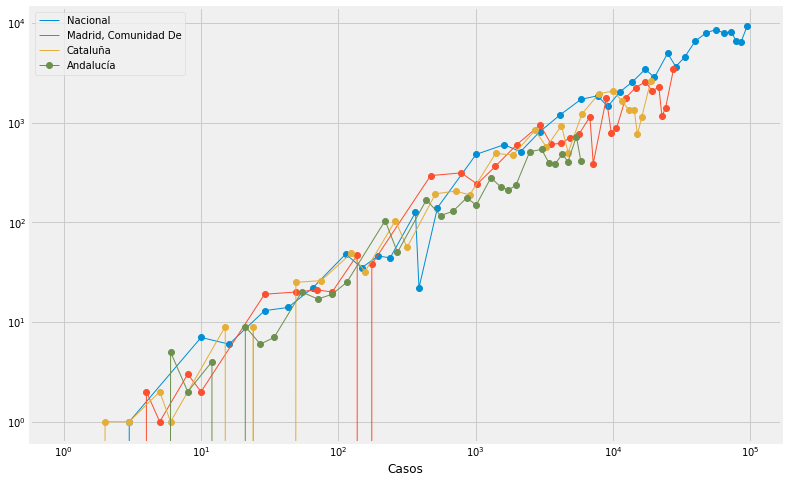

In [26]:
fig, ax = plt.subplots()

selected_ccaa = ['Nacional', 'Madrid, Comunidad De', 'Cataluña', 'Andalucía']

for ccaa in selected_ccaa:
    df[df.CCAA == ccaa].plot(x='Casos', y='nuevosCasos', marker='o', lw=1, ax=ax, label=ccaa, loglog=True, figsize=(12, 8))
    

In [43]:
df.tail()

,Fecha,Casos,Hospitalizados,UCI,Fallecidos,CCAA,nuevosCasos,nuevosHospitalizados,nuevosUCI,nuevosFallecidos,Dias
578,2020-03-24,928.0,254.0,33.0,37.0,"Rioja, La",126.0,48.0,9.0,7.0,23
579,2020-03-25,995.0,316.0,36.0,43.0,"Rioja, La",67.0,62.0,3.0,6.0,24
580,2020-03-26,1236.0,388.0,43.0,55.0,"Rioja, La",241.0,72.0,7.0,12.0,25
581,2020-03-27,1436.0,458.0,43.0,65.0,"Rioja, La",200.0,70.0,0.0,10.0,26
582,2020-03-28,1629.0,497.0,43.0,68.0,"Rioja, La",193.0,39.0,0.0,3.0,27


### Algunas visualizaciones para Madrid

Parece que faltan datos de Hospitalizados, UCI y Fallecidos los primeros días

In [27]:
madrid = df[df.CCAA == 'Madrid, Comunidad De']
madrid.head()

,Fecha,Casos,Hospitalizados,UCI,Fallecidos,Recuperados,CCAA,nuevosCasos,nuevosFallecidos,nuevosRecuperados,nuevosHospitalizados,nuevosUCI,Dias
452,2020-02-25,2.0,0.0,0.0,0.0,0.0,"Madrid, Comunidad De",0.0,0.0,0.0,0.0,0.0,0
453,2020-02-26,4.0,0.0,0.0,0.0,0.0,"Madrid, Comunidad De",2.0,0.0,0.0,0.0,0.0,1
454,2020-02-27,5.0,0.0,0.0,0.0,0.0,"Madrid, Comunidad De",1.0,0.0,0.0,0.0,0.0,2
455,2020-02-28,8.0,0.0,0.0,0.0,0.0,"Madrid, Comunidad De",3.0,0.0,0.0,0.0,0.0,3
456,2020-02-29,10.0,0.0,0.0,0.0,0.0,"Madrid, Comunidad De",2.0,0.0,0.0,0.0,0.0,4


/usr/lib64/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


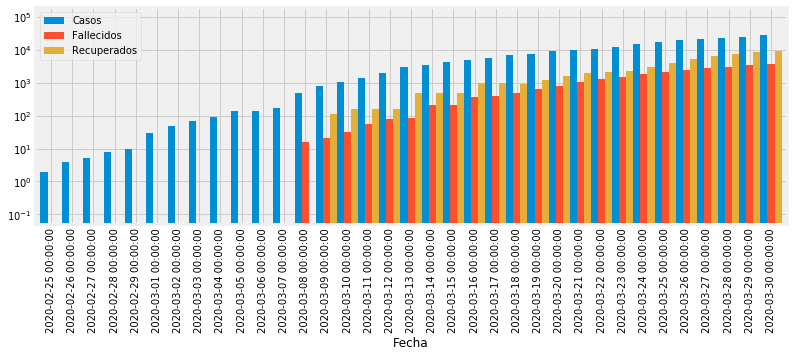

In [28]:
es_madrid = df.CCAA.apply(lambda x: x.find('Madrid') != -1) # otra manera de filtrar por CCAA

fig, ax = plt.subplots()

nuax = df[es_madrid].plot(x='Fecha', y=['Casos', 'Fallecidos', 'Recuperados'],  #'Hospitalizados','UCI', 
                   kind='bar',  width=1.0, figsize=(12,4), logy=True, ax=ax)

nuax.plot([inicio_cuarentena_madrid]*2, [0.1, 10**5], 'k')
fig.show()
#ax.axvline(x=inicio_cuarentena_madrid, ymin=0.1, ymax=10**5, color='k')
#ax.axvline(pd.to_datetime(inicio_cuarentena_madrid), color='k', linestyle='--', lw=10)


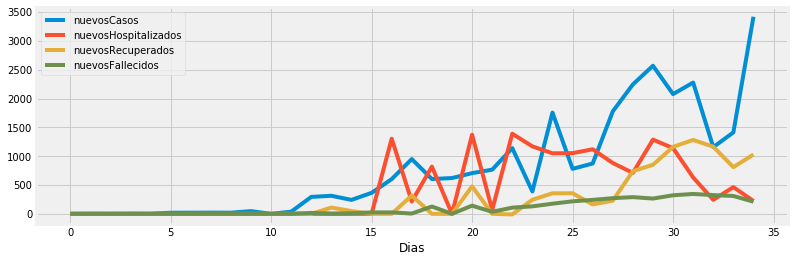

In [29]:
df[es_madrid].plot(x='Dias', y=['nuevosCasos', 'nuevosHospitalizados','nuevosRecuperados', 'nuevosFallecidos'], 
                   kind='line',   figsize=(12,4), logy=False, ) #kind ='bar', width=0.8,